# Árbol de clasificación: ¿Quién llegará al número uno en Billboard 100?

A partir de atributos de cantantes y de un histórico de canciones que llegaron al top 100 de Billboard (U.S.) en 2013 y 2014, se creará un árbol de decisión que permita predecir si un nuevo cantante podrá llegar a la primera posición.

In [181]:
# Importando librerias necesarias
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

from sklearn import tree
from subprocess import check_call
from sklearn.metrics import accuracy_score
from IPython.display import Image as PImage
from PIL import Image, ImageDraw, ImageFont
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')
pd.set_option("max_rows", None)
pd.set_option('max_columns', None)

## Pre procesamiento y exploración 

In [182]:
# carga de datos
billboardOriginal = pd.read_csv('/content/billboard.csv')

In [183]:
billboard = billboardOriginal.copy()
billboard.shape

(635, 11)

Datos de 635 artistas con 11 atributos

In [184]:
billboard.sample(5)

,id,title,artist,mood,tempo,genre,artist_type,chart_date,length_sec,top,year_of_birth
325,325,Superheroes,THE SCRIPT,Empowering,Medium Tempo,Pop,Male,20141004,280,0,0
306,306,Hotel,KID INK featuring CHRIS BROWN,Sensual,Medium Tempo,Urban,Male,20150221,195,0,0
590,590,Explosions,ELLIE GOULDING,Empowering,Slow Tempo,Electronica,Female,20140301,301,0,1986
269,269,Pompeii,BASTILLE,Defiant,Medium Tempo,Alternative & Punk,Male,20140104,264,0,0
510,510,Come Join The Murder,THE WHITE BUFFALO & THE FOREST RANGERS,Melancholy,Medium Tempo,Rock,Male,20141227,206,0,0


### ¿Cuántos alcanzaron el número 1?

In [185]:
billboard.groupby('top').size()

top
0    494
1    141
dtype: int64

494 canciones no alcanzaron el top 1 (label 0) y 141 si lo hicieron (label 1).  Podemos observar que los datos están desbalanceados y esto puede sesgar el árbol.

En el siguiente gráfico se puede apreciar con mayor claridad.

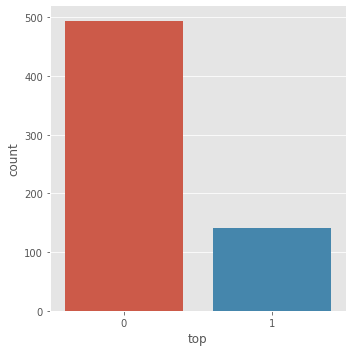

In [186]:
g = sb.catplot(x='top', data=billboard, kind="count")

In [187]:
billboard["artist"].value_counts().sample(10)

ELI YOUNG BAND                           2
VANCE JOY                                1
ERIC CHURCH                              4
CHAMILLIONAIRE featuring KRAYZIE BONE    1
TINASHE featuring SCHOOLBOY Q            1
JENNIFER LOPEZ                           1
SNOOP DOGG                               1
CASSADEE POPE                            1
SCOTTY McCREERY                          1
JAY Z featuring BEYONCE                  1
Name: artist, dtype: int64

Varios artistas han logrado posicionar más de una canción en el top 100.

### Visualización de características

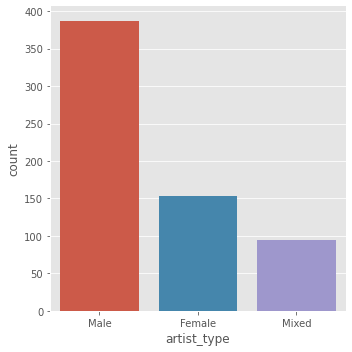

In [188]:
g = sb.catplot(x='artist_type', data=billboard, kind="count")

Se evidencia que hay más del doble de artistas masculinos que femeninos, mientras que sólo hay alrededor de 100 canciones con artistas mixtos.

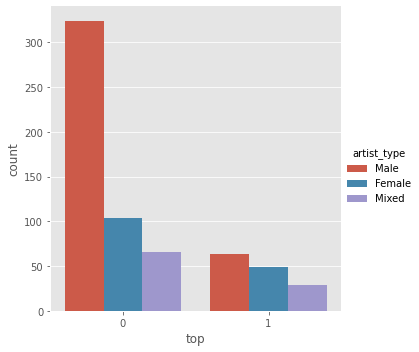

In [189]:
g = sb.catplot(x='top', data=billboard, hue='artist_type', kind="count")

La gran mayoría de las canciones con artistas hombres no alcanzaron el top 1 de Billboard (U.S.)

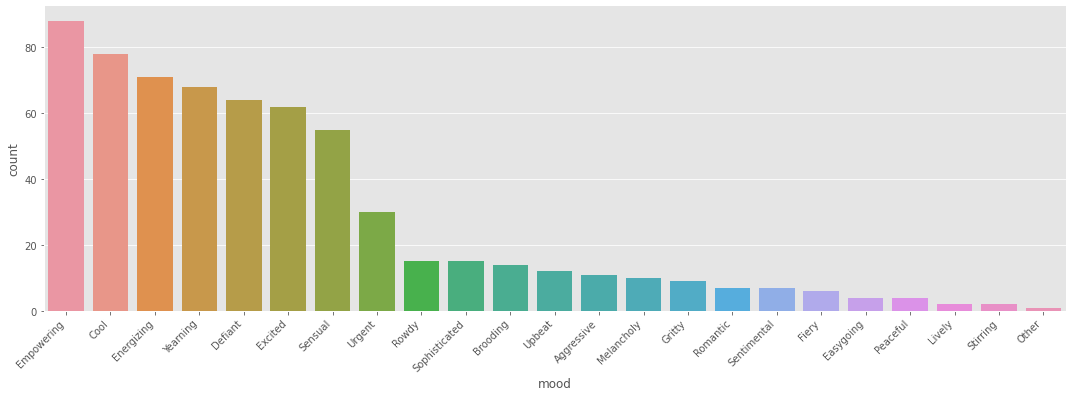

In [190]:
order = ['Empowering','Cool','Energizing','Yearning','Defiant','Excited',
         'Sensual','Urgent','Rowdy','Sophisticated','Brooding','Upbeat',
         'Aggressive','Melancholy','Gritty','Romantic','Sentimental','Fiery',
         'Easygoing','Peaceful','Lively','Stirring','Other']

g = sb.catplot(x='mood', data=billboard, kind="count", aspect=3, order=order)
for axes in g.axes.flat:
    axes.set_xticklabels(axes.get_xticklabels(), rotation=45, horizontalalignment='right') 

De 23 tipos de "mood" hay 7 con mayor cantidad de datos, es decir, las canciones con estos estados de ánimo son mas propensas a entrar en el top 100:

 - Empowering
 - Cool
 - Energizing
 - Yeaning
 - Defiant
 - Excited
 - Sensual

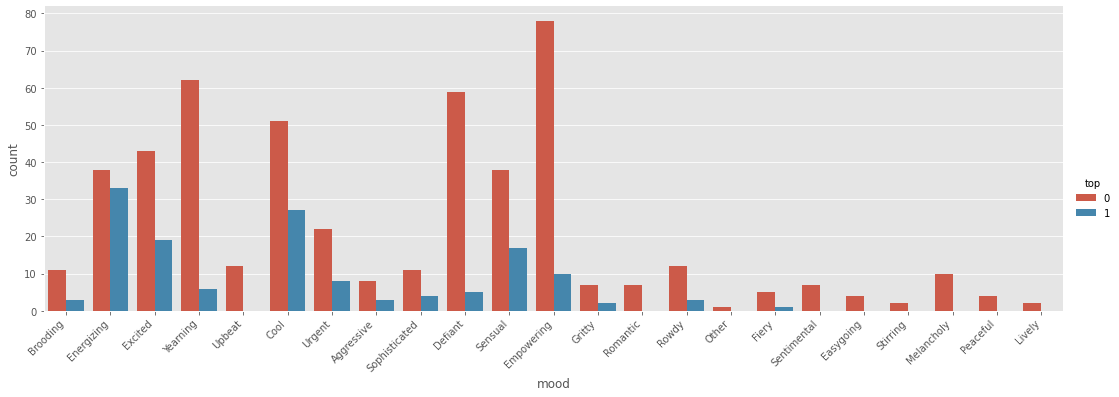

In [191]:
g = sb.catplot(x='mood', data=billboard, hue='top', kind="count", aspect=3)

for axes in g.axes.flat:
    axes.set_xticklabels(axes.get_xticklabels(), rotation=45, horizontalalignment='right') 

Aún así se ve que los estados de ánimo "yearning", "defiant" y "empowering" son de los que menos canciones en top 1 han logrado colocar de estos 7, mientras que "cool" y "energizing" son de los que mas canciones en top 1 tuvieron.

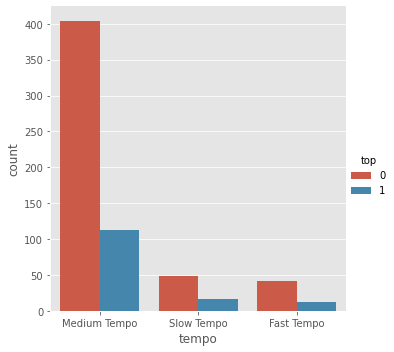

In [192]:
g = sb.catplot(x='tempo', data=billboard, hue='top', kind="count")

Observamos tres tipos de ritmo ("tempo"):

 - Medium
 - Slow
 - Fast

De estos tres el ritmo medio ha sido el que más canciones ha llevado tanto al top 100 como al top 1.

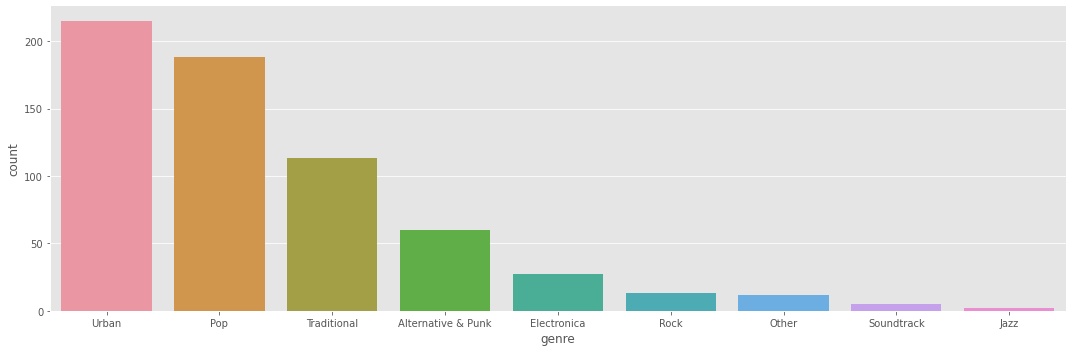

In [193]:
order = ['Urban','Pop','Traditional','Alternative & Punk','Electronica',
         'Rock','Other','Soundtrack','Jazz']
g = sb.catplot(x='genre', data=billboard, kind="count", aspect=3, order=order)

Según el género musical predominan el Urban y el Pop, seguidos por el Tradicional.

In [194]:
# borra registros duplicados por nombre para que la edad de cada artista aparezca solo una vez
unique_artists = billboard.drop_duplicates(billboard.columns[~billboard.columns.isin(['artist'])])

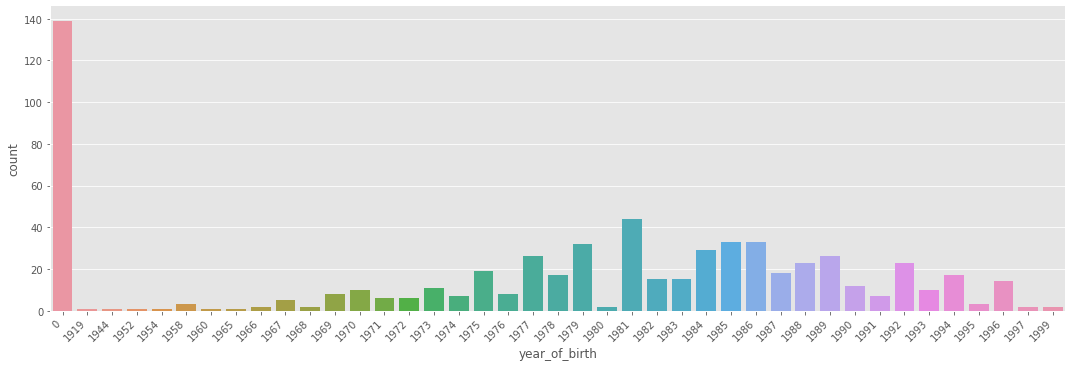

In [195]:
g = sb.catplot(x='year_of_birth', data=unique_artists, kind="count", aspect=3)
for axes in g.axes.flat:
    axes.set_xticklabels(axes.get_xticklabels(), rotation=45, horizontalalignment='right') 

Hay aproximadamente 140 canciones cuyo cantante aparece como nacido en el año cero y esto no tiene mucho sentido.

In [196]:
birthsByYear = billboard['year_of_birth']
len(birthsByYear[birthsByYear<=0])

139

Hay exactamente 139 registros de canciones de las que desconocemos el año de nacimiento del artista. Se debe decidir cómo tratar estos ejemplos antes de proceder a entrenar el árbol.

### Comparando las canciones que llegaron al Top 1 y las que no

Buscamos si hay alguna relación evidente entre año de nacimiento y duración de Canción discriminando por color según la variable objetivo (por ahora ignoramos los artirtas de los cuales desconocemos su año de nacimiento).

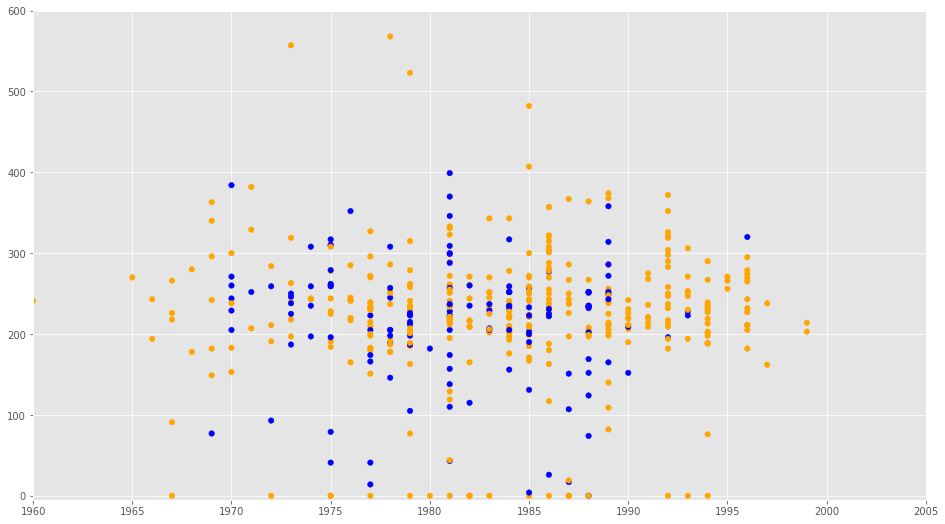

In [197]:
colors=['orange','blue']

f1 = billboard['year_of_birth'].values
f2 = billboard['length_sec'].values

asign=[]
for index, row in billboard.iterrows(): asign.append(colors[row['top']])

plt.scatter(f1, f2, c=asign, s=30)
plt.axis([1960,2005,-5,600])
plt.show()

No parece haber ningún patron aparente, están bastante mezclados los top y los no-top, pero vemos que para algunas canciones (exactamente 31) la duración es de cero segundos y tendremos que tratarla posteriormente.

In [198]:
irregular_songs = billboard['length_sec']
len(irregular_songs[irregular_songs<=0])

31

Ahora veamos la distribución de los Top y no-Top según el año en que llegaron a la lista y la duración de la canción.

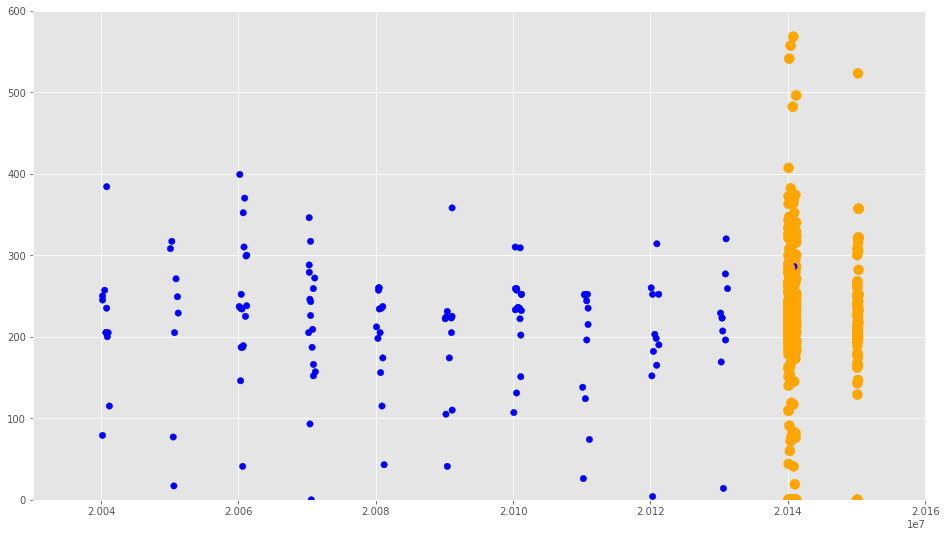

In [199]:
f1 = billboard['chart_date'].values
f2 = billboard['length_sec'].values
size=[100,40]
asign=[]
asign2=[]
for index, row in billboard.iterrows():    
    asign.append(colors[row['top']])
    asign2.append(size[row['top']])

plt.scatter(f1, f2, c=asign, s=asign2)
plt.axis([20030101,20160101,0,600])
plt.show()

Se puede ver que todos los no-Top (amarillos) estan concentrados en dos años, esto se debe a que los datos iniciales se tomaron en 2014 y 2015; había casi 500 registros que no llegaron a top 1 y sólo 11 que si.

Para intentar equilibrar un poco las clases se tomaron los datos de los artistas que llegaron al top 1 entre el 2004 y el 2013, pero aún así el desbalance sigue siendo bastante significativo.

Por lo tanto mas adelante se usará el parametro `class_weight` del modelo (árbol de decisión) para compensar la diferencia.

In [200]:
billboard.drop(['id','chart_date','top'], axis=1).describe()

,length_sec,year_of_birth
count,635.000000,635.000000
mean,321.768504,1548.590551
std,633.753787,820.470454
min,0.000000,0.000000
25%,200.000000,1969.000000
50%,232.000000,1981.000000
75%,266.500000,1986.000000
max,6840.000000,1999.000000


En el resumen estadístico podemos confirmar que tanto el año de nacimiento como la duración de algunas canciones toman valores de 0.

### Calcular edades de los artistas

El objetivo de tener el año de nacimiento de los artistas es saber qué edad tenían al momento de entrar al top 100 de billboard.

Primero convertimos los valores de año de nacimiento cero y duración de canciones cero en NaN, así se pueden ignorar temporalmente y volver a realizar el resumen estadístico y los cálculos necesarios sin que se vean afectador por estos valores atípicos o errados.

In [201]:
# funcion auxiliar para convertir ceros en nan
def fix(predictor):
    if predictor == 0:
        return None
    return predictor

In [202]:
# reemplazo de ceros por nan
billboard['year_of_birth'] = billboard.apply(lambda x: fix(x['year_of_birth']), axis=1)
billboard['length_sec'] = billboard.apply(lambda x: fix(x['length_sec']), axis=1)

In [203]:
billboard.iloc[[4]]

,id,title,artist,mood,tempo,genre,artist_type,chart_date,length_sec,top,year_of_birth
4,4,Automatic,MIRANDA LAMBERT,Yearning,Medium Tempo,Traditional,Female,20140301,232.0,0,NaN


In [204]:
billboard.iloc[[72]]

,id,title,artist,mood,tempo,genre,artist_type,chart_date,length_sec,top,year_of_birth
72,72,Style,TAYLOR SWIFT,Yearning,Medium Tempo,Pop,Female,20141115,NaN,0,1982.0


Visualizamos dos filas que previamente tenian valores de cero en las características de interes para corroborar que el cambio haya surtido efecto.

Realizamos el cálculo de la edad que tenian los artistas al entrar en la lista.

In [205]:
def age(year_of_birth, chart_date):
    chart_date = str(chart_date)
    chart_year = int(chart_date[:4])
    return chart_year - year_of_birth

In [206]:
billboard['age_on_billboard'] = billboard.apply(lambda x: age(x['year_of_birth'],x['chart_date']), axis=1);

añadimos la variable `age_on_billboard` al dataframe, que corresponde a la edad que tenía el artista al llegar al top 100 y eliminamos las columnas usadas para el cálculo.

In [207]:
billboard = billboard.drop(['year_of_birth','chart_date'], axis=1)

In [208]:
billboard.iloc[[4]]

,id,title,artist,mood,tempo,genre,artist_type,length_sec,top,age_on_billboard
4,4,Automatic,MIRANDA LAMBERT,Yearning,Medium Tempo,Traditional,Female,232.0,0,NaN


Ratificamos que los valores NaN no se ven afectados por las operaciones.

### Calculamos el promedio de edad al llegar al top100 y de la duración, y reemplazamos los registros nulos

In [209]:
age_avg = billboard['age_on_billboard'].mean()
age_std = billboard['age_on_billboard'].std()
age_null_count = billboard['age_on_billboard'].isnull().sum()
# lista de valores aleatorios a partir de la media y la std
age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)

withNullValues = np.isnan(billboard['age_on_billboard'])

billboard.loc[withNullValues, 'age_on_billboard'] = age_null_random_list
billboard['age_on_billboard'] = billboard['age_on_billboard'].astype(int)
print("Edad Promedio: " + str(age_avg))
print("Desviación Std Edad: " + str(age_std))
print("Intervalo para asignar edad aleatoria: " + str(int(age_avg - age_std)) + " a " + str(int(age_avg + age_std)))

Edad Promedio: 30.10282258064516
Desviación Std Edad: 8.40078832861513
Intervalo para asignar edad aleatoria: 21 a 38


In [210]:
dur_avg = billboard['length_sec'].mean()
# en este caso la desv est es tan alta que produce valores negativos,
# por tanto elegimos una cantidad arbitraria que no afecte la duración
dur_std = 60
dur_null_count = billboard['length_sec'].isnull().sum()
# lista de valores aleatorios a partir de la media y la std
dur_null_random_list = np.random.randint(dur_avg - dur_std, dur_avg + dur_std, size=dur_null_count)

nullValues = np.isnan(billboard['length_sec'])

billboard.loc[nullValues, 'length_sec'] = dur_null_random_list
print("Duración Promedio: " + str(dur_avg))
print("Margen Duración: " + str(dur_std))
print("Intervalo para asignar duración aleatoria: " + str(dur_avg - dur_std) + " a " + str(dur_avg + dur_std))

Duración Promedio: 338.2831125827815
Margen Duración: 60
Intervalo para asignar duración aleatoria: 278.2831125827815 a 398.2831125827815


In [211]:
billboard.iloc[[4]]

,id,title,artist,mood,tempo,genre,artist_type,length_sec,top,age_on_billboard
4,4,Automatic,MIRANDA LAMBERT,Yearning,Medium Tempo,Traditional,Female,232.0,0,33


In [212]:
billboard.iloc[[72]]

,id,title,artist,mood,tempo,genre,artist_type,length_sec,top,age_on_billboard
72,72,Style,TAYLOR SWIFT,Yearning,Medium Tempo,Pop,Female,291.0,0,32


### Visualizamos las edades y duraciones agregadas

In [213]:
billboard.describe()

,id,length_sec,top,age_on_billboard
count,635.000000,635.000000,635.000000,635.000000
mean,317.000000,338.685039,0.222047,29.995276
std,183.452991,629.596419,0.415950,7.794581
min,0.000000,4.000000,0.000000,15.000000
25%,158.500000,206.000000,0.000000,25.000000
50%,317.000000,235.000000,0.000000,29.000000
75%,475.500000,276.500000,0.000000,35.000000
max,634.000000,6840.000000,1.000000,95.000000


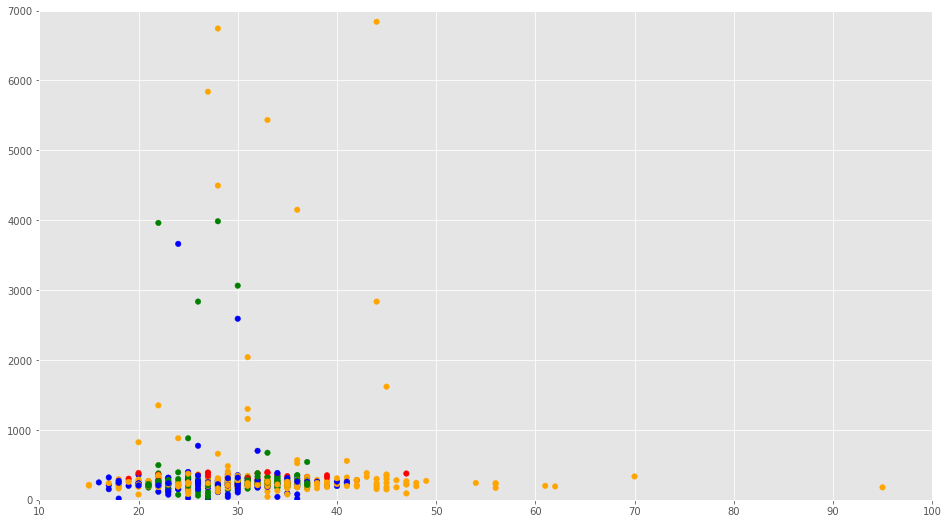

In [214]:
colors = ['orange','blue','green', 'red']

f1 = billboard['age_on_billboard'].values
f2 = billboard['length_sec'].values

asign=[]
for index, row in billboard.iterrows():
    # edades reemplazadas
    if (withNullValues[index]):
      asign.append(colors[2]) # verde
    # duraciones
    elif nullValues[index]:
      asign.append(colors[3]) # rojo
    else:
      asign.append(colors[row['top']])

plt.scatter(f1, f2, c=asign, s=30)
plt.axis([10,100,0,7000]) #650
plt.show()

Podemos ver que hay algunos valores bastante dispersos; lo ideal sería tratarlos de alguna forma, pero por ahora los dejaremos y acotaremos el grafico para ver la concentración un poco mejor.

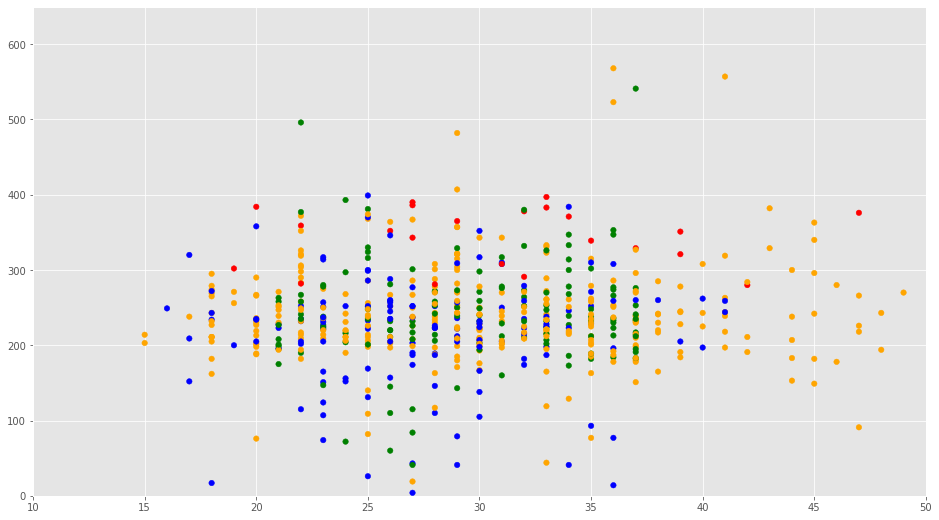

In [215]:
plt.scatter(f1, f2, c=asign, s=30)
plt.axis([10,50,0,650])
plt.show()

Graficando los artistas por edad y duración podemos ver en azul los que alcanzaron el top 1, mientras que los naranja son los que no llegaron, además, en verde vemos las edades y en rojo las duraciones que acabamos de llenar con el promedio.

### Mapeo de Atributos

Realizaremos un mapeo de los atributos de entrada para poder transformarlos a categorias que podamos utilzar en nuestro árbol de decisión.

Empezamos por ver las categorias y la cantidad de elementos en ellas.

In [216]:
def ver(variable):
  grouped11 = billboard.groupby(variable).size()
  neworder11 = grouped11.sort_values(ascending=False)
  print(neworder11)
  print()

print("Estados de animo:")
ver('mood')

print("Ritmos de Canción:")
ver('tempo')

print("Genero:")
ver('genre')

print("Tipos de Artista:")
ver('artist_type')

Estados de animo:
mood
Empowering       88
Cool             78
Energizing       71
Yearning         68
Defiant          64
Excited          62
Sensual          55
Urgent           30
Sophisticated    15
Rowdy            15
Brooding         14
Upbeat           12
Aggressive       11
Melancholy       10
Gritty            9
Romantic          7
Sentimental       7
Fiery             6
Peaceful          4
Easygoing         4
Lively            2
Stirring          2
Other             1
dtype: int64

Ritmos de Canción:
tempo
Medium Tempo    517
Slow Tempo       65
Fast Tempo       53
dtype: int64

Genero:
genre
Urban                 215
Pop                   188
Traditional           113
Alternative & Punk     60
Electronica            27
Rock                   13
Other                  12
Soundtrack              5
Jazz                    2
dtype: int64

Tipos de Artista:
artist_type
Male      387
Female    153
Mixed      95
dtype: int64



Ahora pasaremos de tener 23 estados de animo a tener 7 agrupando moods que puedan resultar similares

In [217]:
# Mood Mapping 
billboard['moodEncoded'] = billboard['mood'].map( {'Energizing': 6, 
                                        'Empowering': 6,
                                        'Cool': 5, 
                                        'Yearning': 4, #anhelo, deseo, ansia
                                        'Excited': 5, #emocionado
                                        'Defiant': 3, 
                                        'Sensual': 2, 
                                        'Gritty': 3, #coraje 
                                        'Sophisticated': 1,
                                        'Aggressive': 4, #provocativo
                                        'Fiery': 4, #caracter fuerte
                                        'Urgent': 3, 
                                        'Rowdy': 4, #ruidoso
                                        'Sentimental': 4,
                                        'Easygoing': 1, #sencillo
                                        'Melancholy': 4, 
                                        'Romantic': 2, 
                                        'Peaceful': 1, 
                                        'Brooding': 4, #melancolico
                                        'Upbeat': 5, #optimista alegre
                                        'Stirring': 5, #emocionante
                                        'Lively': 5, #animado
                                        'Other': 0,
                                        '': 0}).astype(int)

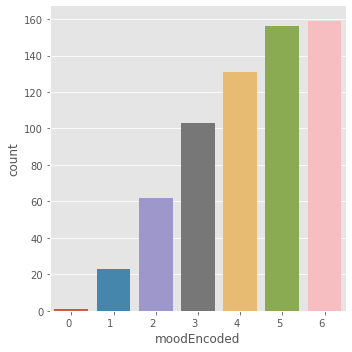

In [218]:
g = sb.catplot(x='moodEncoded', data=billboard, kind="count")
for axes in g.axes.flat:
    axes.set_xticklabels(axes.get_xticklabels(), rotation=0, horizontalalignment='right') 

esto se hace asignando valores entre 0 y 6, según su similitud (se pueden agrupar diferente si lo considera conveniente)

In [219]:
# Tempo Mapping 
billboard['tempoEncoded'] = billboard['tempo'].map( {
    'Fast Tempo': 0, 
    'Medium Tempo': 2, 
    'Slow Tempo': 1, 
    '': 0} ).astype(int)

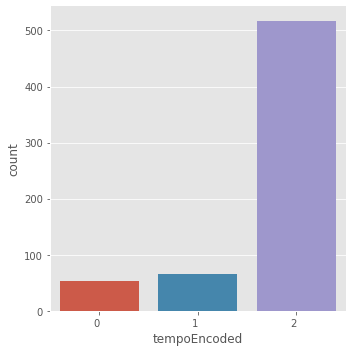

In [220]:
g = sb.catplot(x='tempoEncoded', data=billboard, kind="count")
for axes in g.axes.flat:
    axes.set_xticklabels(axes.get_xticklabels(), horizontalalignment='right') 

Se codifica el ritmo con valores entre 0 y 2 de acuerdo a la cantidad de canciones que tiene cada "tempo".

In [221]:
# Genre Mapping 
billboard['genreEncoded'] = billboard['genre'].map( {'Urban': 4, 
                                          'Pop': 3, 
                                          'Traditional': 2, 
                                          'Alternative & Punk': 1,
                                          'Electronica': 1, 
                                          'Rock': 1, 
                                          'Soundtrack': 0, 
                                          'Jazz': 0,
                                          'Other':0,'':0} 
                                       ).astype(int)

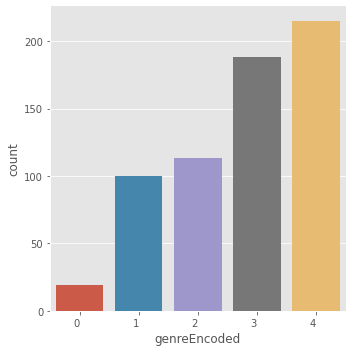

In [222]:
g = sb.catplot(x='genreEncoded', data=billboard, kind="count")
for axes in g.axes.flat:
    axes.set_xticklabels(axes.get_xticklabels(), horizontalalignment='right') 

Agrupandolos también por similaridad del género pasamos de 9 a 5 categorias.



In [223]:
# artist_type Mapping 
billboard['artist_typeEncoded'] = billboard['artist_type'].map( {
    'Female': 2, 
    'Male': 3, 
    'Mixed': 1, 
    '': 0} ).astype(int)

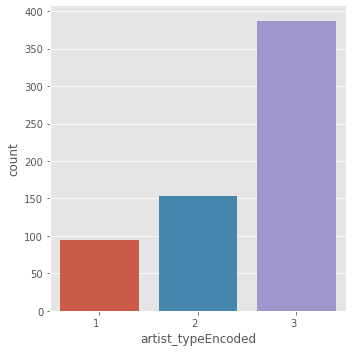

In [224]:
g = sb.catplot(x='artist_typeEncoded', data=billboard, kind="count")
for axes in g.axes.flat:
    axes.set_xticklabels(axes.get_xticklabels(), horizontalalignment='right') 

Dando valores entre 0 y 3 de acuerdo con el tipo de artista

In [225]:
# Mapping edad en la que llegaron al billboard
billboard_edad = billboard['age_on_billboard']

billboard.loc[ billboard_edad <= 21, 'edadEncoded']	= 0
billboard.loc[(billboard_edad > 21) & (billboard_edad <= 26), 'edadEncoded'] = 1
billboard.loc[(billboard_edad > 26) & (billboard_edad <= 30), 'edadEncoded'] = 2
billboard.loc[(billboard_edad > 30) & (billboard_edad <= 40), 'edadEncoded'] = 3
billboard.loc[ billboard_edad > 40, 'edadEncoded'] = 4

In [226]:
billboard['edadEncoded'] = billboard['edadEncoded'].astype(int)

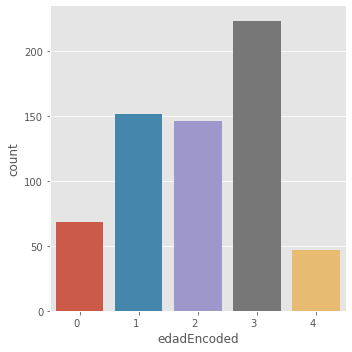

In [227]:
g = sb.catplot(x='edadEncoded', data=billboard, kind="count")
for axes in g.axes.flat:
    axes.set_xticklabels(axes.get_xticklabels(), horizontalalignment='right') 

Cambiando por rangos entre 0 y 4:
   - Menor o igual que 21 años = 0
   - Mayor a 21 y menor o igual que 26 = 1
   - Mayor a 26 y menor o igual que 30 = 2
   - Mayor a 30 y menor o igual que 40 = 3
   - Mayor a 40 = 4

In [228]:
# Mapping Song Duration
billboard_seg = billboard['length_sec']
billboard.loc[ billboard_seg <= 150, 'durationEncoded']	= 0
billboard.loc[(billboard_seg > 150) & (billboard_seg <= 180), 'durationEncoded'] = 1
billboard.loc[(billboard_seg > 180) & (billboard_seg <= 210), 'durationEncoded'] = 2
billboard.loc[(billboard_seg > 210) & (billboard_seg <= 240), 'durationEncoded'] = 3
billboard.loc[(billboard_seg > 240) & (billboard_seg <= 270), 'durationEncoded'] = 4
billboard.loc[(billboard_seg > 270) & (billboard_seg <= 300), 'durationEncoded'] = 5
billboard.loc[ billboard_seg > 300, 'durationEncoded'] = 6

In [229]:
billboard['durationEncoded'] = billboard['durationEncoded'].astype(int)

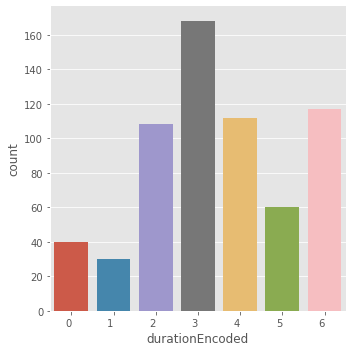

In [230]:
g = sb.catplot(x='durationEncoded', data=billboard, kind="count")
for axes in g.axes.flat:
    axes.set_xticklabels(axes.get_xticklabels(), horizontalalignment='right') 

Y de la misma manera para la duración de la canción en segundos

In [231]:
drop_elements = ['id',
                 'title',
                 'artist',
                 'mood',
                 'tempo',
                 'genre',
                 'artist_type',
                 'length_sec',
                 'age_on_billboard'
                ]
artists_encoded = billboard.drop(drop_elements, axis = 1)

Ahora que tenemos todo codificado nos deshacemos de la información que no nos es de utilidad para entrenar el modelo.


In [233]:
artists_encoded.sample(8)

,top,moodEncoded,tempoEncoded,genreEncoded,artist_typeEncoded,edadEncoded,durationEncoded
441,0,3,2,4,3,2,2
229,0,6,2,2,3,2,5
615,1,4,2,3,2,1,0
444,0,4,2,3,1,1,6
479,0,5,2,2,3,2,4
329,0,6,2,2,3,4,3
120,1,4,2,3,2,1,1
424,1,5,2,4,3,2,1


## Gráfica de correlación de Pearson

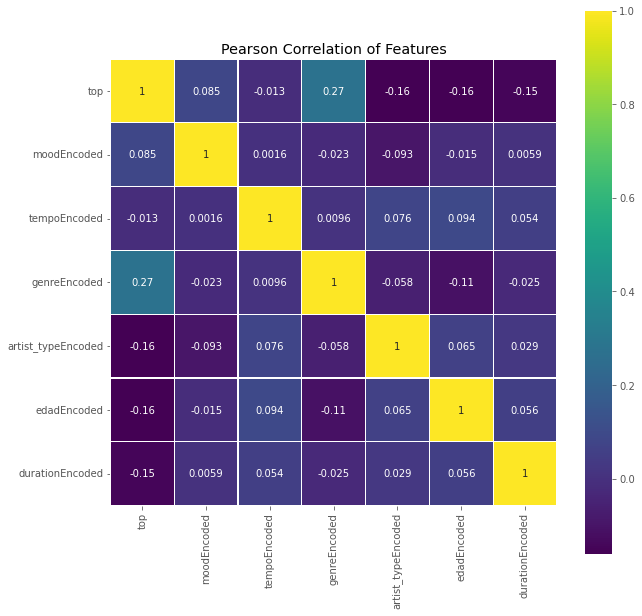

In [262]:
colormap = plt.cm.viridis
plt.figure(figsize=(10,10))
plt.title('Pearson Correlation of Features')
sb.heatmap(artists_encoded.astype(float).corr(),
           vmax=1.0,
           cmap=colormap,
           annot=True,
           linewidths=0.1,
           linecolor='white',
           square=True)

## Matriz de correlación de Cramer V
Para datos categóricos

In [263]:
data_encoded = artists_encoded.copy()

In [264]:
from scipy.stats import chi2_contingency

def cramers_V(var1, var2):
  crosstab = np.array(pd.crosstab(var1, var2, rownames=None, colnames=None))
  stat = chi2_contingency(crosstab)[0]
  obs = np.sum(crosstab)
  mini = min(crosstab.shape) - 1
  return (stat/(obs*mini))

In [265]:
rows= []

for var1 in data_encoded:
  col = []
  for var2 in data_encoded :
    cramers =cramers_V(data_encoded[var1], data_encoded[var2])
    col.append(round(cramers,2))
  rows.append(col)
  
cramers_results = np.array(rows)
df = pd.DataFrame(cramers_results, columns = data_encoded.columns, index =data_encoded.columns)


df

,top,moodEncoded,tempoEncoded,genreEncoded,artist_typeEncoded,edadEncoded,durationEncoded
top,0.99,0.03,0.00,0.11,0.03,0.04,0.04
moodEncoded,0.03,1.00,0.05,0.05,0.01,0.01,0.01
tempoEncoded,0.00,0.05,1.00,0.01,0.00,0.01,0.01
genreEncoded,0.11,0.05,0.01,1.00,0.05,0.03,0.01
artist_typeEncoded,0.03,0.01,0.00,0.05,1.00,0.01,0.01
edadEncoded,0.04,0.01,0.01,0.03,0.01,1.00,0.01
durationEncoded,0.04,0.01,0.01,0.01,0.01,0.01,1.00


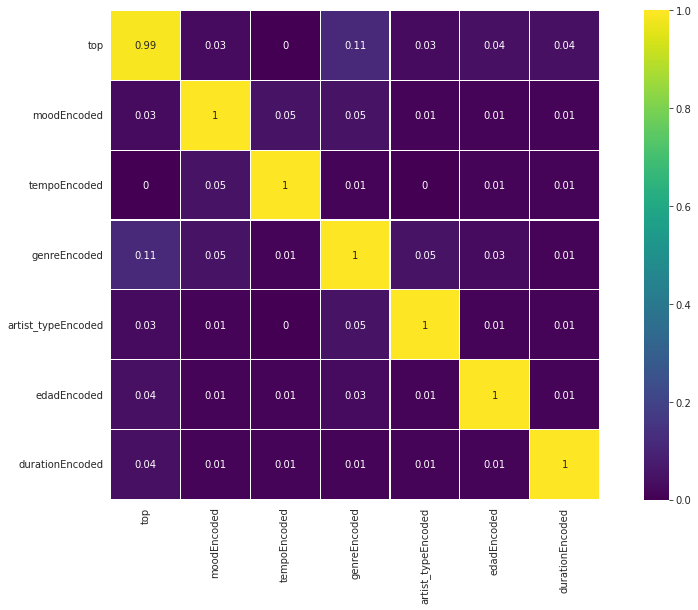

In [266]:
with sb.axes_style("white"):
  ax = sb.heatmap(df,
                  vmin=0.,
                  vmax=1,
                  cmap=colormap,
                  annot=True,
                  linewidths=0.1,
                  square=True)

plt.show()

Según esta gráfica la correlación entre variables es mínima, por lo que usarlas todas en nuestro modelo nos aportará información

# Como quedan los top en relacion con los datos mapeados?

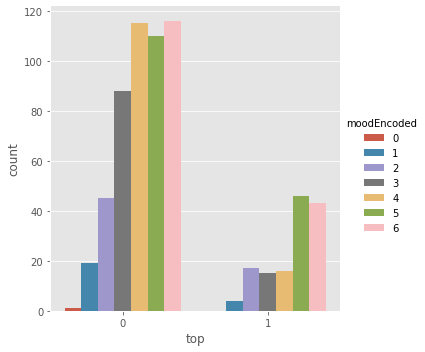

In [268]:
g = sb.catplot(x='top', data=artists_encoded, hue='moodEncoded', kind="count")

In [270]:
artists_encoded[['moodEncoded', 'top']].groupby(['moodEncoded'], as_index=False).agg(['count', 'sum'])

top    
            count sum
moodEncoded          
0               1   0
1              23   4
2              62  17
3             103  15
4             131  16
5             156  46
6             159  43

La mayoría de los top 1 están en el "mood" 5 y 6  con 46 y 43 canciones

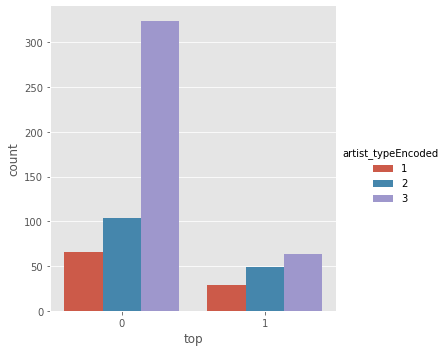

In [272]:
g = sb.catplot(x='top', data=artists_encoded, hue='artist_typeEncoded', kind="count")

In [274]:
artists_encoded[['artist_typeEncoded', 'top']].groupby(['artist_typeEncoded'], as_index=False).agg(['count', 'sum'])

top    
                   count sum
artist_typeEncoded          
1                     95  29
2                    153  49
3                    387  63

Hay una "buena" distribución de datos aunque se ve que mayormente están en los artistas de tipo 3 (Masculinos)

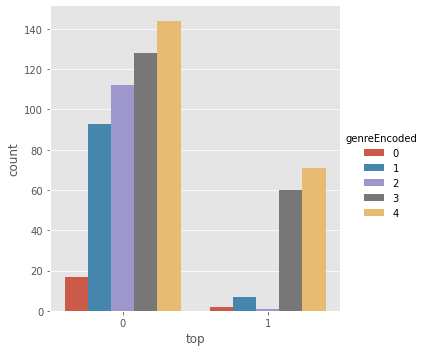

In [275]:
g = sb.catplot(x='top', data=artists_encoded, hue='genreEncoded', kind="count")

In [280]:
artists_encoded[['genreEncoded', 'top']].groupby(['genreEncoded'], as_index=False).agg(['count', 'sum'])

top    
             count sum
genreEncoded          
0               19   2
1              100   7
2              113   1
3              188  60
4              215  71

Como era de esperarse la mayoría de los top estan en los genero 3 y 4 que son Urbano y Pop

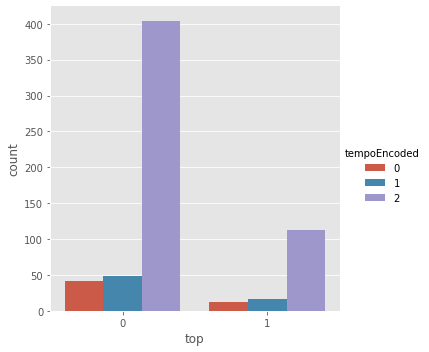

In [277]:
g = sb.catplot(x='top', data=artists_encoded, hue='tempoEncoded', kind="count")

In [279]:
artists_encoded[['tempoEncoded', 'top']].groupby(['tempoEncoded'], as_index=False).agg(['count', 'sum'])

top     
             count  sum
tempoEncoded           
0               53   12
1               65   16
2              517  113

De la misma manera el "tempo" con mas canciones en el top 1 es el 2, tempo medio

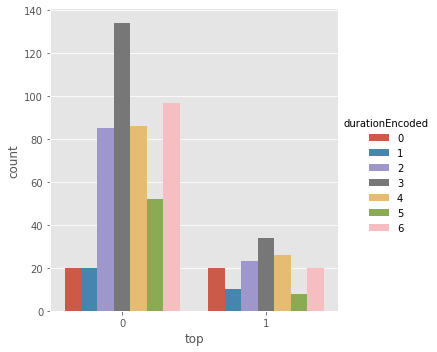

In [282]:
g = sb.catplot(x='top', data=artists_encoded, hue='durationEncoded', kind="count")

In [283]:
artists_encoded[['durationEncoded', 'top']].groupby(['durationEncoded'], as_index=False).agg(['count', 'sum'])

top    
                count sum
durationEncoded          
0                  40  20
1                  30  10
2                 108  23
3                 168  34
4                 112  26
5                  60   8
6                 117  20

Respecto a la duración de las canciones están bastante repartidas aunque se ve una mayoría en la duracion 3

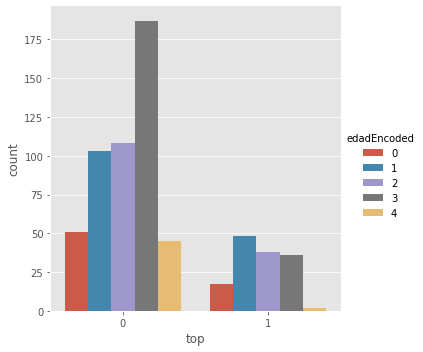

In [284]:
g = sb.catplot(x='top', data=artists_encoded, hue='edadEncoded', kind="count")

In [285]:
artists_encoded[['edadEncoded', 'top']].groupby(['edadEncoded'], as_index=False).agg(['count', 'sum'])

top    
            count sum
edadEncoded          
0              68  17
1             151  48
2             146  38
3             223  36
4              47   2

La mayoría de los artistas que logran llevar una canción al Top 1 están en el rango 1, que corresponde a edades entre 21 y 25 años

# Buscamos nuestro Arbol de Decisión

K-Fold permite partir los datos en k folds consecutivos. Cada fold es usado una vez como conjunto de validación mientras que los k-1 restantes forman el conjunto de entrenamiento. Esto permite usar todos los datos para “tunear” los hiper parámetros del árbol (profundidad, minimo de muestras en una hoja...) y evitar el desperdicio de información al crear un conjunto de validación (solo se dividen en datos de entrenamiento y prueba).

Como estamos ante una tarea de clasificación y no de regresión, usamos de la libreria sklearn tree.DecisionTreeClassifier:

 - criterion: se puede elegir entre "entropy" (ganancia de infromación) o gini.
 - min_samples_split: cantidad mínima de muestras que debe tener un nodo para subdividirse
 - min_samples_leaf:  cantidad mínima de muestras que debe tener un nodo hoja
 - class_weight: compensa de cierta manera el desbalance de clases (top 0 [494] dividido entre los top 1 [141] da 3.5)

todos estos parametros salen de prueba y error, visualizar los datos y el arbol y volver a intentar.


In [286]:
X = artists_encoded.drop(['top'], axis=1)
y = artists_encoded['top'] 

In [287]:
X = np.array(X)
y = np.array(y)

In [288]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1) # Numero de "folds" en que se dividen los datos
accuracies = list()
max_attributes = len(list(artists_encoded))
depth_range = range(1, max_attributes + 1)

# Testearemos la profundidad de 1 a cantidad de atributos +1
for depth in depth_range:
    fold_accuracy = []
    tree_model = tree.DecisionTreeClassifier(criterion='entropy',
                                             min_samples_split=20,
                                             min_samples_leaf=5,
                                             max_depth = depth,
                                             class_weight={0:1, 1:3.5}) # Por defecto todas las clases tienen peso 1
                                                                        # tambien se puede usar 'balanced'
    for train_index, valid_index in cv.split(X, y):
        X_train, X_test = X[train_index], X[valid_index]
        y_train, y_test = y[train_index], y[valid_index]

        model = tree_model.fit(X_train, y_train)
        valid_acc = model.score(X_test, y_test) # calculamos la precision con el segmento de validacion
        fold_accuracy.append(valid_acc)

    # almacenamos acc promedio para cada profundidad
    avg = sum(fold_accuracy)/len(fold_accuracy)
    accuracies.append(avg)
    
# Mostramos los resultados obtenidos
df = pd.DataFrame({"Max Depth": depth_range, "Average Accuracy": accuracies})
df = df[["Max Depth", "Average Accuracy"]]
print(df.to_string(index=False))

 Max Depth  Average Accuracy
         1          0.555977
         2          0.555977
         3          0.571726
         4          0.571677
         5          0.659896
         6          0.640997
         7          0.653423


# Creamos el Arbol de Decisión

In [289]:
# Dividimos los datos para entrenamiento y prueba
X = artists_encoded.drop(['top'], axis=1)
y = artists_encoded['top']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2,
                                                    stratify = y,
                                                    random_state = 1)

In [296]:
conteo = X_train.copy()
conteo['label'] = y_train
conteo.groupby('label').size()

label
0    395
1    113
dtype: int64

In [301]:
w = 395/113
w

3.495575221238938

In [338]:
# Instanciar Arbol de decision con profundidad = 5
decision_tree = tree.DecisionTreeClassifier(criterion='entropy',
                                            min_samples_split=20,
                                            min_samples_leaf=6,
                                            max_depth = 6,
                                            # class_weight='balanced',
                                            class_weight={0:1, 1:w},
                                            random_state=6)

In [339]:
# Ajustamos el modelo con los datos
decision_tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight={0: 1, 1: 3.495575221238938},
                       criterion='entropy', max_depth=6, min_samples_leaf=6,
                       min_samples_split=20, random_state=6)

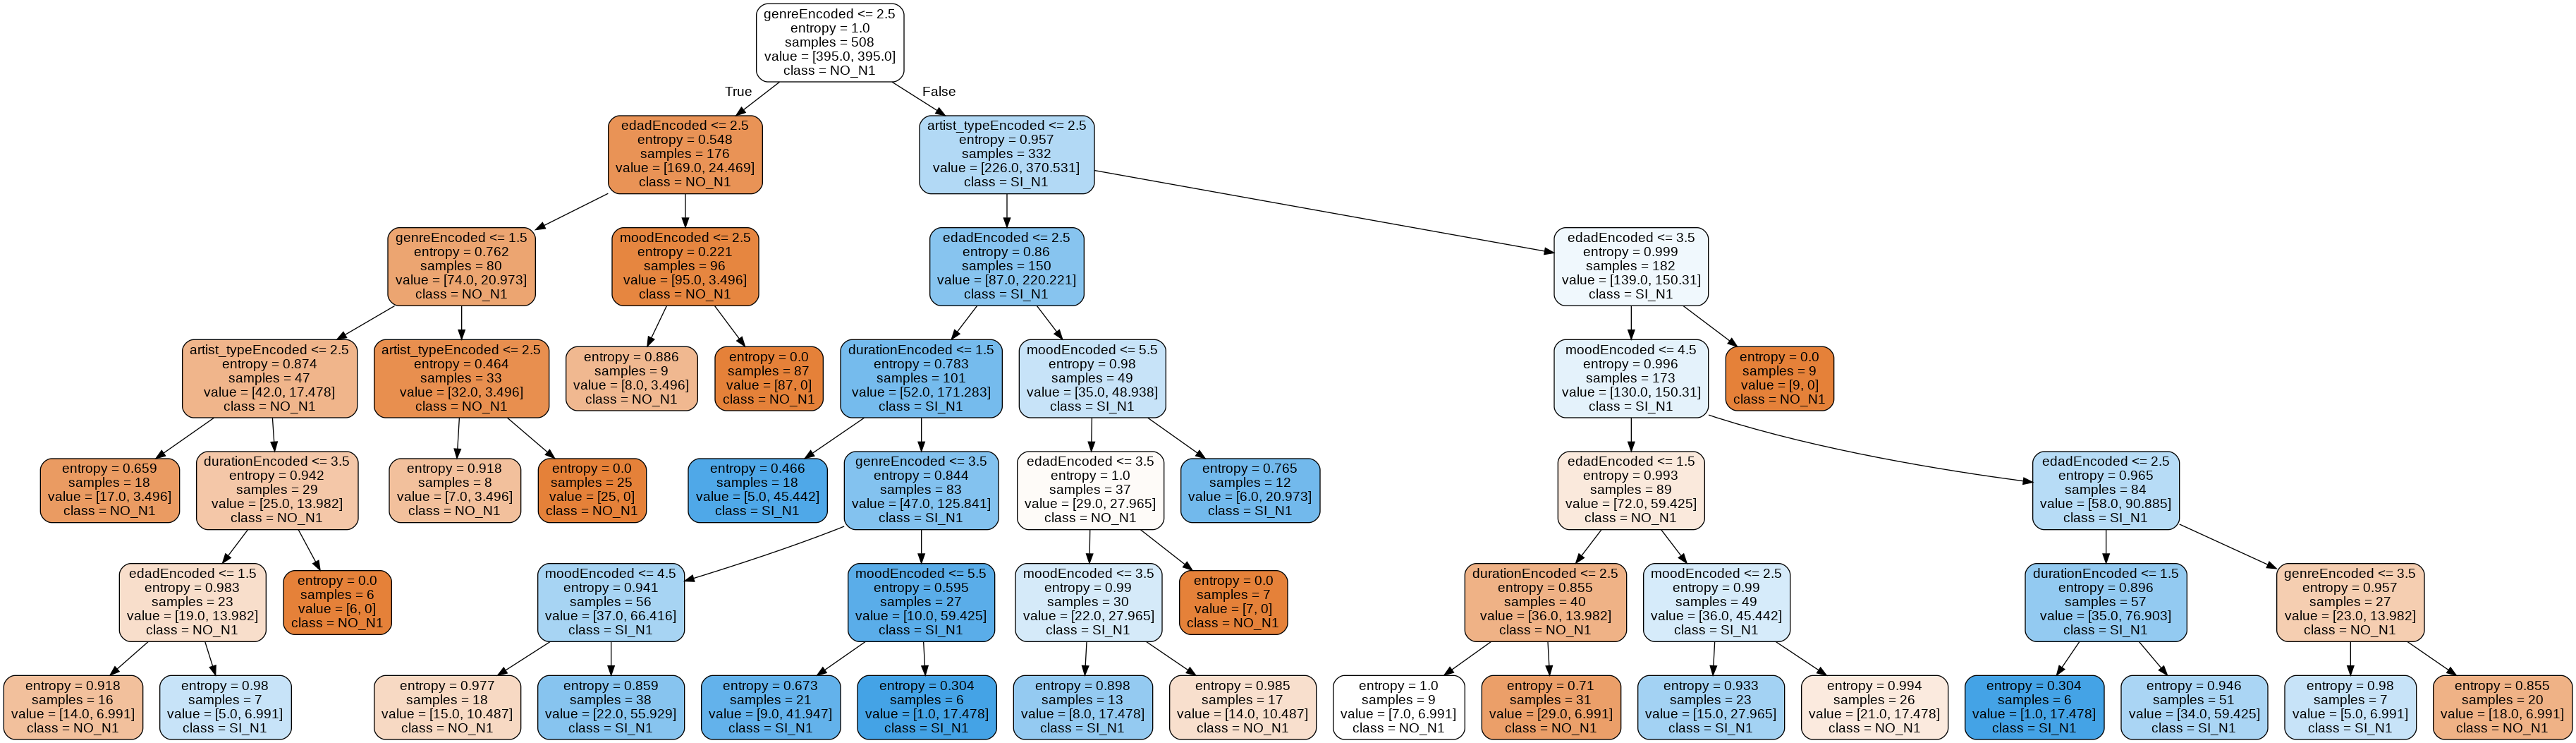

In [340]:
# exportar el modelo a archivo .dot y graficar
with open(r"tree1.dot", 'w') as f:
     f = tree.export_graphviz(decision_tree,
                              out_file=f,
                              max_depth = 6,
                              impurity = True,
                              feature_names = list(artists_encoded.drop(['top'], axis=1)),
                              class_names = ['NO_N1', 'SI_N1'],
                              rounded = True,
                              filled= True )
        
# Convertir el archivo .dot a png para poder visualizarlo
check_call(['dot','-Tpng',r'tree1.dot','-o',r'tree1.png'])
PImage("tree1.png")

### Precisión del árbol con datos de entrenamiento

In [341]:
y_pred_train = decision_tree.predict(X_train)

In [342]:
acc_train = accuracy_score(y_train, y_pred_train)
print("Train set accuracy: {:.2f}".format(acc_train))

Train set accuracy: 0.74


### Precisión del árbol con datos de prueba

In [343]:
y_pred_test = decision_tree.predict(X_test)

In [344]:
acc_test = accuracy_score(y_test, y_pred_test)
print("Test set accuracy: {:.2f}".format(acc_test))

Test set accuracy: 0.71


# Predicción del árbol de decisión

In [345]:
#predecir artista CAMILA CABELLO featuring YOUNG THUG
# con su canción Havana llego a numero 1 Billboard US en 2017

x_test = pd.DataFrame(columns=('top','moodEncoded', 'tempoEncoded', 'genreEncoded','artist_typeEncoded','edadEncoded','durationEncoded'))
x_test.loc[0] = (1,5,2,4,1,0,3)
y_pred = decision_tree.predict(x_test.drop(['top'], axis = 1))
print("Prediccion: " + str(y_pred))
y_proba = decision_tree.predict_proba(x_test.drop(['top'], axis = 1))
print("Probabilidad de Acierto: " + str(np.round(y_proba[0][y_pred]* 100, 2)) + "%")

Prediccion: [1]
Probabilidad de Acierto: [82.33]%


In [346]:
#predecir artista Imagine Dragons 
# con su canción Believer llego al puesto 42 Billboard US en 2017

x_test = pd.DataFrame(columns=('top','moodEncoded', 'tempoEncoded', 'genreEncoded','artist_typeEncoded','edadEncoded','durationEncoded'))
x_test.loc[0] = (0,4,2,1,3,2,3)
y_pred = decision_tree.predict(x_test.drop(['top'], axis = 1))
print("Prediccion: " + str(y_pred))
y_proba = decision_tree.predict_proba(x_test.drop(['top'], axis = 1))
print("Probabilidad de Acierto: " + str(np.round(y_proba[0][y_pred]* 100, 2))+"%")

Prediccion: [1]
Probabilidad de Acierto: [58.3]%
